# Imports

In [1]:
import random as rd
import os
import math
from math import sqrt
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot as plot
from matplotlib.pyplot import figure as figure
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns

/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Class definitions

## Female

In [464]:
class female:
    
    def __init__(self, f, genes=[0,0,0,0]):
        
        self.ID = f
        self.status, self.cycleDay = "nonCycling", False
        self.conceptionProbability, myConceptionProbabilityList = 0, []
        self.nonCyclingLength = randint(rangeOfNonCyclingDays+1)
        self.daysUntilCycling = self.nonCyclingLength
        self.daysUntilConception = False
        self.myConceptionProbabilityList = []
        self.genes = genes
        self.reproductiveSuccess = 0
        self.cost = 0
        
    def switchToCycling(self):
            
        self.cycleDay = 0
        self.status = "cycling"
        self.cyclingLength = abs(round(normal(meanDaysToConception, sdDaysToConception)))
        self.daysUntilConception = self.cyclingLength
        self.conceptionProbability = conceptionProbabilityList[0]
        
    def switchToDone(self):
        
        self.cycleDay = False
        self.status = "done"
        

## Male

In [3]:
class male:
    
    def __init__(self, m, genes=[0,0,0,0]):
        
        self.noise = 1/((1/environmentalNoise)-1)
        self.ID = m
        self.genes = genes
        self.quality = (((self.genes[0] + self.genes[1]) / 2) + uniform(0,self.noise)) / (1 + self.noise)
        self.rankQualityCorrelation = (self.genes[2] + self.genes[3]) / 2
        self.rank = 0
        self.cost = 0
        self.reproductiveSuccess = 0
        self.matings = 0

## Group

In [620]:
class group:
    
    def __init__(self, g):

        self.ID = g
        self.females = [female(f,genes=uniform(0,1,4)) for f in range(nFemales)]
        self.males = [male(m,genes=uniform(0,1,4)) for m in range(nMales)]
        self.modelDays = 0
        self.setRanks()
        
    def go(self):
        
        self.males = sorted(self.males, key=self.sortRank)

        for r in range(10000):
            self.modelDays += 1
            if all([item.status == "done" for item in self.females]):
                break

            #self.females = sorted(self.females, key=self.sortConceptionProbability, reverse = True)
            self.females = permutation(self.females)
            
            self.conceptionProbabilities = [f.conceptionProbability for f in self.females]
            
            self.makeMatingPairs() if any(self.conceptionProbabilities) else 0

            for f in [item for item in self.females if item.status == "cycling"]:
                f.daysUntilConception -= 1
                f.cycleDay = f.cycleDay + 1 if f.cycleDay < cycleLength - 1 else 0
                f.conceptionProbability = conceptionProbabilityList[f.cycleDay]
                f.myConceptionProbabilityList += [conceptionProbabilityList[f.cycleDay]]
                f.switchToDone() if f.daysUntilConception == 0 else 0

            for f in [item for item in self.females if item.status == "nonCycling"]:
                f.daysUntilCycling -= 1
                f.myConceptionProbabilityList += [0]
                f.switchToCycling() if f.daysUntilCycling <= 0 else 0

            for f in [item for item in self.females if item.status == "done"]:
                f.myConceptionProbabilityList += [0]
        
        self.p = [m.reproductiveSuccess for m in self.males]
            
        if self.ID == 0:
            model.listOfRSCorrels += [corrcoef([nMales-m.rank for m in self.males],[m.reproductiveSuccess for m in self.males])[1,0]]
            model.listOfQualityRSCorrels += [corrcoef([m.quality for m in self.males],[m.reproductiveSuccess for m in self.males])[1,0]]
        
    def sortQuality(self, m):
        return m.quality
    
    def sortRank(self, m):
        return m.rank
    
    def sortConceptionProbability(self, f):
        return f.conceptionProbability + uniform(0.0001)
    
    def setRanks(self):
        
        # empty list for each males' number of entries
        self.maleRankEntries = []
        
        # compile a list of all males' rankQualityCorrelations
        rankQualityCorrelations = [m.rankQualityCorrelation for m in self.males]
        
        # for each male, his entries correspond to his quality * 100 if his rankQualityCorrelation is above threshold,
        # otherwise, his number of entries is random
        # also, add his number of entries to the list of entries
        for m in self.males:
            #self.entries = m.quality if uniform(0,1) < m.rankQualityCorrelation else uniform(0,1) #abs(normal(0.0,0.334))
            self.entries = (m.quality * m.rankQualityCorrelation)**4
            self.maleRankEntries += [self.entries + 0.0000000001]
        
        # scale males' number of entries so that proportions are the same but they sum to 1 (necessary for next step)
        self.maleRankEntries = [e / sum(self.maleRankEntries) for e in self.maleRankEntries]
        
        # select males one by on based on their proportional size in entries list (p parameter takes list of weights)
        self.males = choice(self.males, p=self.maleRankEntries, size=nMales, replace = False)
        
        for i, m in enumerate(self.males):
            m.rank = i
            m.cost = m.rankQualityCorrelation
    
    def makeMatingPairs(self):
        
        nPairs = len([item for item in self.females if item.status == "cycling"])
        for m,f in zip(self.males[:nPairs], self.females[:nPairs]):
            m.reproductiveSuccess += f.conceptionProbability# * m.quality**(1/10)
            f.reproductiveSuccess += f.conceptionProbability# * m.quality**(1/10)
            m.matings += 1
        
    def setupNextGen(self):
                
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess for f in self.females]
        # lack of ability to chose becomes a cost as rankQualityCorrelation  goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = np.array([m.reproductiveSuccess - m.cost for m in self.males]) # does male quality matter?
        #fatherProbabilities[fatherProbabilities < 0] = 0
                
        parentsStartingPoint = model.generation * model.nAgents
        
        moms = [rdchoices(model.potentialMoms[parentsStartingPoint+i: parentsStartingPoint+i+2],
                          weights=[motherProbabilities[p] for p in model.potentialMoms[
                              parentsStartingPoint+i: parentsStartingPoint+i+2]],k = 1)[0] for i in np.arange(0, (model.nAgents * 2), 2)]
        dads = [rdchoices(model.potentialDads[parentsStartingPoint+i:parentsStartingPoint+i+2],
                          weights=[fatherProbabilities[p] for p in model.potentialDads[
                              parentsStartingPoint+i: parentsStartingPoint+i+2]], k = 1)[0] for i in np.arange(0, (model.nAgents * 2), 2)]
        
        self.nextGenMotherGenes = [self.females[m].genes.copy() for m in moms]
        self.nextGenFatherGenes = [self.males[d].genes.copy() for d in dads]
                
#     def recombination(self):
        
#         self.offspringGenes = []
#         recombinationPoints = choice(range(model.numberGenes), model.nAgents)
#         splitTypes = randint(0,2, model.nAgents)
#         i = 0
#         while i < model.nAgents:
#             recombinationPoint = recombinationPoints[i]
#             if splitTypes[i] == 1:
#                 self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] + 
#                                            [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
#             else:
#                 self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] + 
#                                            [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
#             i += 1
            
    def recombination(self):

        self.offspringGenes = []
        splitTypes = randint(0,2, model.nAgents)
        i = 0
        while i < model.nAgents:
            if splitTypes[i] == 1:
                self.offspringGenes.append(self.nextGenMotherGenes[i])
            else:
                self.offspringGenes.append(self.nextGenFatherGenes[i])
            i += 1
            
    def mutation(self):
        
        genesInGroup = model.nAgents
        mutations = model.mutations[model.generation - 1]
                
        offspringsMutating = choice(range(model.nAgents), mutations, replace=False)

        genesMutating = choice([0,1,2,3], mutations)
        pertubations = uniform(-0.04,0.04, mutations)
        
        newGenes = nparray([self.offspringGenes[offspringsMutating[m]][genesMutating[m]] + pertubations[m] for m in range(mutations)])
        
        newGenes[newGenes < 0] = 0
        
        for m in range(mutations):
            self.offspringGenes[offspringsMutating[m]][genesMutating[m]] = newGenes[m]
            
    def scaleQuality(self):
        
        for gene in [0,1]:
            qualityDict = {g:self.offspringGenes[g][gene] + uniform(-0.00001,0.00001) for g in range(model.nAgents)}
            
            qualityList = [v for k,v in qualityDict.items()]
            qualityList = (qualityList - np.min(qualityList))/np.ptp(qualityList)
            
#             qualityDict = dict(sorted(qualityDict.items(), key=lambda x: x[1]))
#             i = 0
#             for k,v in qualityDict.items():
#                 qualityDict[k]= i * (1 / (model.nAgents - 1))
#                 i += 1
                
#             qualityDict = dict(sorted(qualityDict.items(), key=lambda x: x[0]))
            
#             qualityList = [v for k,v in qualityDict.items()]


            for g in range(model.nAgents):
                self.offspringGenes[g][gene] = qualityList[g]
                        
    def reset(self):
        
        self.modelDays = 0
        self.males, self.females = [], []
        self.males = [male(m,genes=self.offspringGenes[m + nFemales]) for m in range(nMales)]
        self.females = [female(f, genes=self.offspringGenes[f]) for f in range(nFemales)]
        self.setRanks()
        
        
cycleLength = 28
ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


## Population

In [5]:
class population:
    
    def __init__(self):
        
        self.listOfQualityCorrels = []
        self.listOfRSCorrels = []
        self.listOfQualityRSCorrels = []
        self.generation = 0
        self.numberGenes = 2
        self.rangeFemales = range(nFemales)
        self.rangeMales = range(nMales)
        self.nAgents = nMales + nFemales
        self.totalAgents = nGroups * self.nAgents
        self.rangeGroups = range(nGroups)
        self.mutations = [round(uniform(0,self.nAgents * mutationRate * 2)) for i in range(nGenerations * nGroups)]
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.potentialDads = rdchoices(range(nMales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.groups = [group(g) for g in self.rangeGroups]
    
    def evolve(self):

        %matplotlib qt

        for gen in tqdm(range(nGenerations)):

            self.listOfQualityCorrels += [corrcoef([nMales-m.rank for m in self.groups[0].males],[m.quality for m in self.groups[0].males])[1,0]]
            
            self.plotRankQuality() if uniform(0,1) > 0.8 else 0
               
            self.generation += 1

            for group in self.groups:
                group.go()
                
                rankList = [nMales-m.rank for m in self.groups[0].males] if self.generation == nGenerations else 0
                
                self.geneticAlgorithm(group) if self.generation < nGenerations else 0
                
        %matplotlib inline
        plt.plot(rankList, self.groups[0].p)        
        
    def geneticAlgorithm(self,group=group):
        
        group.setupNextGen()
        
        group.recombination()
        
        group.mutation() if model.mutations[model.generation - 1] > 0 else 0
        
        group.scaleQuality()
        
        group.reset()
                
        self.migration() if dispersal else 0
        
    def migration(self):
                
        migrations = round(uniform(self.totalAgents * migrationRate * 2))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.males[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).males)
            else:
                agentLeaving = groupLeavingFrom.females[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).females)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost

    def plotRankQuality(self):
        
        plt.clf()
        plt.plot([m.quality for m in self.groups[0].males], [nMales-m.rank for m in self.groups[0].males], 'bo')
        plt.text(0.1, nMales*0.8
                 ,
             str(round(corrcoef([nMales-m.rank
                                  for m
                                  in self.groups[0].males],[m.quality
                                                            for m
                                                            in self.groups[0].males])[1,0],2)))
        plt.xlim([0,1.2])
        plt.ylim([0,nMales*1.2])
        plt.pause(0.00001)
        plt.show()
        

# Notes

1. Initially, rankQualityCorreltion converges on a single value relatively quickly for the same reasons that quality used to

# Model tests


  8%|▊         | 152/2000 [00:36<06:20,  4.85it/s]


 15%|█▌        | 303/2000 [01:18<05:35,  5.07it/s]


 23%|██▎       | 455/2000 [02:01<08:34,  3.00it/s]


 30%|███       | 606/2000 [02:38<04:21,  5.34it/s]


 38%|███▊      | 757/2000 [03:15<07:29,  2.76it/s]


 45%|████▌     | 908/2000 [03:52<05:03,  3.60it/s]


 53%|█████▎    | 1058/2000 [04:29<03:24,  4.60it/s]


 60%|██████    | 1206/2000 [05:05<02:41,  4.93it/s]


 68%|██████▊   | 1354/2000 [05:44<02:53,  3.72it/s]


 75%|███████▌  | 1502/2000 [06:20<02:09,  3.86it/s]


 82%|████████▎ | 1650/2000 [06:59<01:39,  3.51it/s]


 90%|████████▉ | 1798/2000 [07:39<00:51,  3.91it/s]


 97%|█████████▋| 1946/2000 [08:14<00:17,  3.14it/s]


100%|██████████| 2000/2000 [08:27<00:00,  3.94it/s]


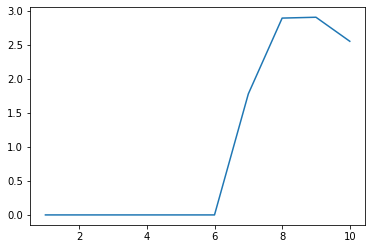

In [621]:
nGenerations = 2000
mutationRate = 0.1

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5
environmentalNoise = 0.25
startingCorrel = 0.5

nFemales = 10
nMales = 10
nGroups = 5

seasonality = 0.0

meanDaysToConception = 60
sdDaysToConception = 50 * (1.0 - seasonality)



model = population()
model.evolve()

# palette = np.flip(sns.color_palette("viridis",100))

# fig,ax = plt.subplots(figsize=[12,12])
# plt.title("Correlations Between Rank and Quality Over Time", size = 20)
# plt.xlabel("Generation", size = 17)
# plt.ylabel("Correlation", size = 17)

# for i,s in enumerate([0.0,0.2,0.4,0.6,0.8,1.0]):
#     seasonality = s
#     meanDaysToConception = 60
#     sdDaysToConception = 50 * (1.0 - seasonality)
    
#     rangeOfNonCyclingDays = 365 - (365 * seasonality)

#     model = population()
#     model.evolve()

#     listOfQualityCorrels_split = np.array_split(model.listOfQualityCorrels,10)
#     ax.plot([np.nanmean(j) for j in listOfQualityCorrels_split],color=palette[i*12], linewidth=3,label=s)
#     ax.legend(loc='best')
#     plt.close()
    

In [622]:
cols = ["Quality", "GeneQual","Correl","Rank","RS","Matings","Cost", "RS - Cost",
        "QualGene1","QualGene2","Noise","CorrGene1","CorrGene2"]
IDs = [m.ID for m in model.groups[0].males]

df = pd.DataFrame(
    [
        [m.quality, (m.genes[0]+m.genes[1])/2,m.rankQualityCorrelation, m.rank, m.reproductiveSuccess,
         m.matings/model.groups[0].modelDays,m.cost,m.reproductiveSuccess-m.cost, m.genes[0],m.genes[1],m.noise,m.genes[2],m.genes[3]
        ] for i,m in enumerate(model.groups[0].males)
    ], columns=cols,index=IDs).round(3).sort_values(by="Rank", ascending=True)

pd.set_option('display.max_rows', df.shape[0]+1)
df

,Quality,GeneQual,Correl,Rank,RS,Matings,Cost,RS - Cost,QualGene1,QualGene2,Noise,CorrGene1,CorrGene2
0,0.896,0.934,0.868,0,2.555,0.680,0.868,1.688,0.868,1.000,0.333,0.964,0.772
2,0.799,0.934,0.868,1,2.909,0.562,0.868,2.041,0.868,1.000,0.333,0.964,0.772
4,0.824,0.815,0.824,2,2.897,0.484,0.824,2.073,0.796,0.834,0.333,0.931,0.717
9,0.798,0.815,0.832,3,1.781,0.221,0.832,0.949,0.796,0.834,0.333,0.931,0.733
1,0.820,0.954,0.832,4,0.000,0.004,0.832,-0.832,0.985,0.924,0.333,0.931,0.733
6,0.420,0.439,0.873,5,0.000,0.000,0.873,-0.873,0.877,0.000,0.333,0.931,0.816
8,0.578,0.706,0.873,6,0.000,0.000,0.873,-0.873,1.000,0.412,0.333,0.931,0.816
5,0.764,0.815,0.824,7,0.000,0.000,0.824,-0.824,0.796,0.834,0.333,0.931,0.717
3,0.544,0.500,0.868,8,0.000,0.000,0.868,-0.868,0.000,1.000,0.333,0.964,0.772
7,0.379,0.478,0.868,9,0.000,0.000,0.868,-0.868,0.000,0.955,0.333,0.964,0.772


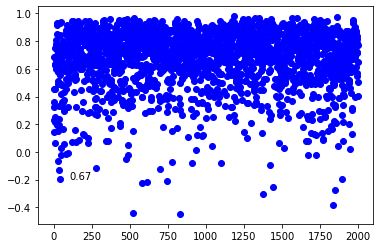

In [625]:
figure()
p = plt.plot(model.listOfQualityCorrels, 'bo')
t = plt.text(100, -0.2, round(np.nanmean(model.listOfQualityCorrels),2))

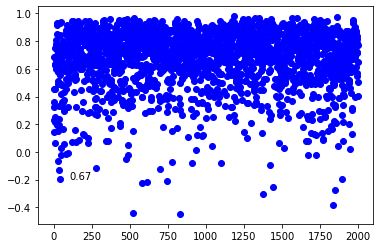

In [624]:
figure()
p = plt.plot(model.listOfQualityCorrels, 'bo')
t = plt.text(100, -0.2, round(np.nanmean(model.listOfQualityCorrels),2))

In [ ]:
i = 3
plt.plot([m.genes[1] for m in model.groups[i].males],[m.genes[3] for m in model.groups[i].males],'bo')
corrcoef([m.genes[1] for m in model.groups[i].males],[m.genes[3] for m in model.groups[i].males])[0,1]

In [ ]:
i = 4
plt.plot([m.quality for m in model.groups[i].males],[m.rank for m in model.groups[i].males],'bo')
corrcoef([m.quality for m in model.groups[i].males],[m.rank for m in model.groups[i].males])[0,1]


In [561]:
seasonality = 1.0

meanDaysToConception = 60
sdDaysToConception = 10 * (1.0 - seasonality)

nGenerations = 1000=]
mutationRate = 0.1

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5
environmentalNoise = 0.5
startingCorrel = 1.0

nFemales = 10
nMales = 10
nGroups = 5

#seasonality = s
rangeOfNonCyclingDays = 365 - (365 * seasonality)

In [564]:
seasonality = 1.0
sdDaysToConception = 50 * (1.0 - seasonality)

g = group(0)
g.go()

/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [560]:
cols = ["Quality", "GeneQual","Correl","Entries","Rank","RS","Matings","Cost", "RS - Cost",
        "QualGene1","QualGene2","Noise","CorrGene1","CorrGene2"]
IDs = [m.ID for m in g.males]

entries = [(m.quality * m.rankQualityCorrelation)**4 for m in g.males]
entries = [e / sum(entries) for e in entries]

df = pd.DataFrame(
    [
        [m.quality, (m.genes[0]+m.genes[1])/2,m.rankQualityCorrelation, entries[i], m.rank, m.reproductiveSuccess,
         m.matings/g.modelDays,m.cost,m.reproductiveSuccess-m.cost, m.genes[0],m.genes[1],m.noise,m.genes[2],m.genes[3]
        ] for i,m in enumerate(g.males)
    ], columns=cols,index=IDs).round(3).sort_values(by="RS - Cost", ascending=False)

df

,Quality,GeneQual,Correl,Entries,Rank,RS,Matings,Cost,RS - Cost,QualGene1,QualGene2,Noise,CorrGene1,CorrGene2
2,0.607,0.315,1.0,0.093,0,2.037,0.194,1.0,1.037,0.079,0.551,1.0,1.0,1.0
9,0.670,0.772,1.0,0.139,1,2.037,0.194,1.0,1.037,0.668,0.876,1.0,1.0,1.0
5,0.800,0.765,1.0,0.282,2,2.037,0.194,1.0,1.037,0.905,0.626,1.0,1.0,1.0
7,0.588,0.517,1.0,0.082,3,2.037,0.194,1.0,1.037,0.150,0.884,1.0,1.0,1.0
0,0.473,0.401,1.0,0.035,4,2.037,0.194,1.0,1.037,0.359,0.444,1.0,1.0,1.0
8,0.786,0.639,1.0,0.263,5,2.037,0.194,1.0,1.037,0.982,0.296,1.0,1.0,1.0
1,0.605,0.404,1.0,0.092,6,2.037,0.194,1.0,1.037,0.430,0.378,1.0,1.0,1.0
4,0.286,0.301,1.0,0.005,7,2.037,0.194,1.0,1.037,0.562,0.040,1.0,1.0,1.0
3,0.327,0.588,1.0,0.008,8,2.037,0.194,1.0,1.037,0.617,0.559,1.0,1.0,1.0
6,0.231,0.457,1.0,0.002,9,2.037,0.194,1.0,1.037,0.694,0.219,1.0,1.0,1.0


## Variable checks

# Exploratory data anlysis

In [533]:
def synchronyCharts(group):
    
    plt.figure(figsize=(20, 9))
    allDays = plt.scatter([range(group.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                        for i in range(group.modelDays)]
                                       for f in group.females], s=8)

    totalProb = [0] * group.modelDays

    for i in range(group.modelDays):
        totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in group.females]) - 2
    
    textList = [0] * group.modelDays
    for i in range(group.modelDays):
        textList[i] = sum([f.myConceptionProbabilityList[i] > 0 for f in g.females])
        
    linesList = [0] * group.modelDays
    for i in range(group.modelDays):
        #if sum([f.myConceptionProbabilityList[i] > 0 for f in g.females]) > 1:
        linesList[i] = sum(
            [f.myConceptionProbabilityList[i]
             for f in g.females]) if sum([f.myConceptionProbabilityList[i] > 0
                                                                           for f in g.females]) > 1 else 0
    
    #scalingLinesList = nFemales/max(textList)
    scalingLinesList = 6/max(textList)
    linesList = (linesList - np.min(linesList))/np.ptp(linesList)
    linesList = [l/scalingLinesList for l in linesList]
    
    allDaysTotal = plt.scatter([range(group.modelDays)], totalProb)
    
    plt.vlines(x=range(group.modelDays), ymin=0, ymax=nFemales+1,
               colors=([(0.99,0,0,l) for l in linesList]), lw=[(l>0)*3 for l in linesList])
    plt.vlines(x=range(group.modelDays), ymin=0, ymax=nFemales+1,
               colors=(0.0,0,0.99,0.99), lw=[(l==0) for l in linesList])
    
    j = 0
    lastNum,up = 0,False
    for i, num in enumerate(textList):
        if lastNum > 1 and num > 1 and up==False:
            j,up = 0.65,True
        else:
            j,up = 0,False
        plt.annotate(num, (i, nFemales + 1.5 + j),size=16) if num > 1 else 0
        lastNum = num

    plt.ylim([-3,nFemales + 3])
    
    figure(figsize=[20,5])

    dailyCyclingFemales = [day
                           for days in [[i for i in range(f.nonCyclingLength,f.nonCyclingLength+f.cyclingLength)]
                                        for f in group.females] for day in days]

    numOfCyclingFemalesByDay = [dailyCyclingFemales.count(num) for num in range(group.modelDays)]

    plt.bar(range(group.modelDays),numOfCyclingFemalesByDay)
    
    plt.ylim([0,nFemales])
    
    groupConceptionProbabilities = []
    lenFertilePerDay = group.modelDays
    
    for d in range(group.modelDays):
        groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1
                                              for f in group.females])]

    fertilePerDay = [groupConceptionProbabilities.count(i) / group.modelDays for i in range(nFemales + 1)]

    for day in np.flip(range(len(fertilePerDay))):
        if fertilePerDay[day] ==  0:
            fertilePerDay.pop(day)
        else:
            break

    t = 0
    for i in range(len(fertilePerDay)):
        t += (groupConceptionProbabilities.count(i) / group.modelDays)
        fertilePerDay += [t]


    d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                      [f for f in range(round(len(fertilePerDay)/2))]*2,
                      ["day" for f in range(round(len(fertilePerDay)/2))] +
                      ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                     index=["numberFertile", "day", "category"]).T

    plt.figure(figsize=(18, 5))
    fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

    plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
    plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
    xlabel = plt.xlabel('Number of females in POP', size=25)
    ylabel = plt.ylabel('Average number of days per cycle', size=25)
    ylim = plt.ylim([0,110])
    

In [534]:
meanDaysToConception = 60
sdDaysToConception = 50 * (1.0 - seasonality)

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post



/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


62
412


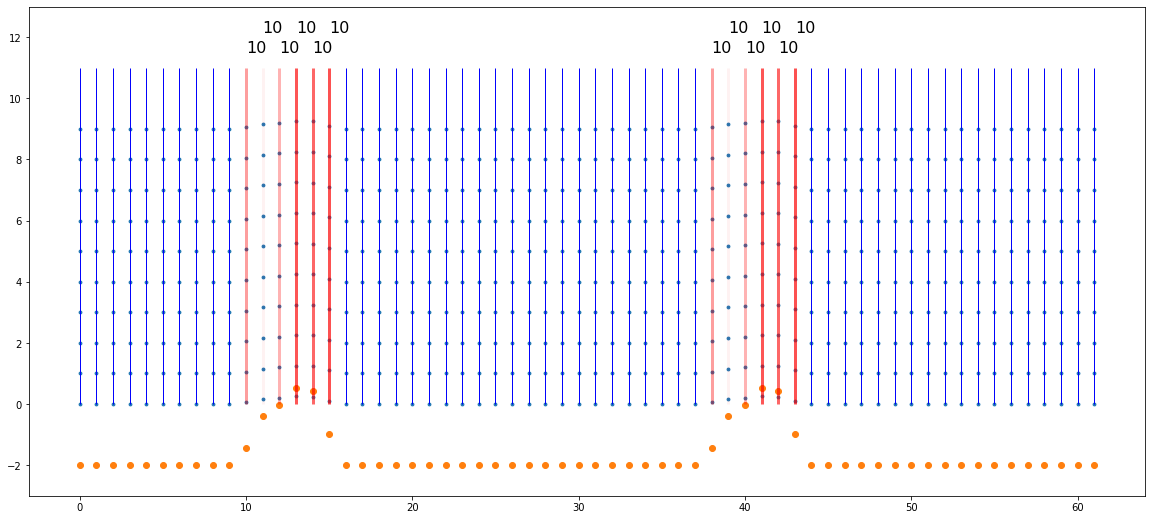

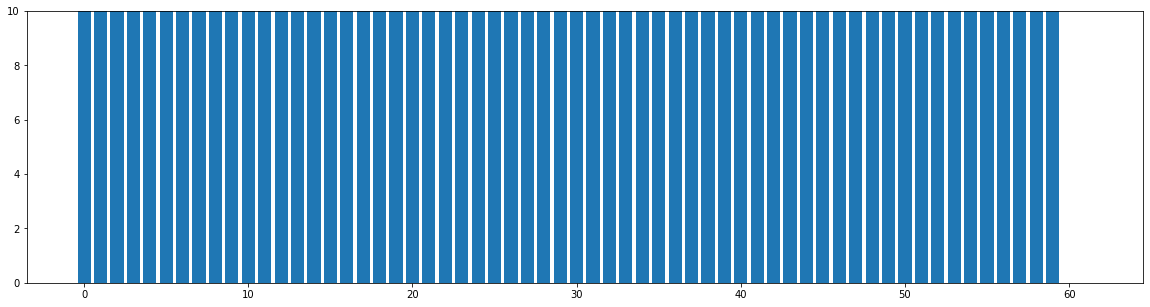

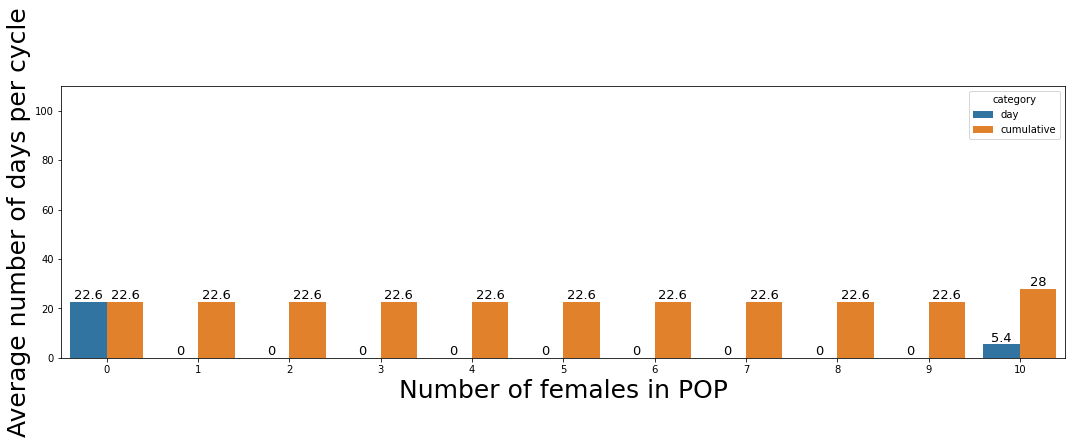

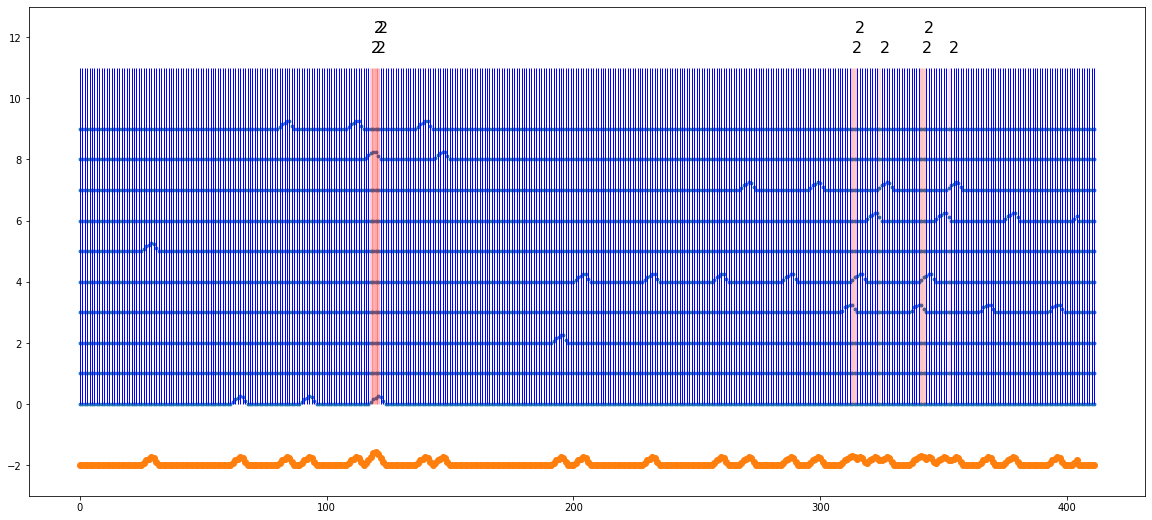

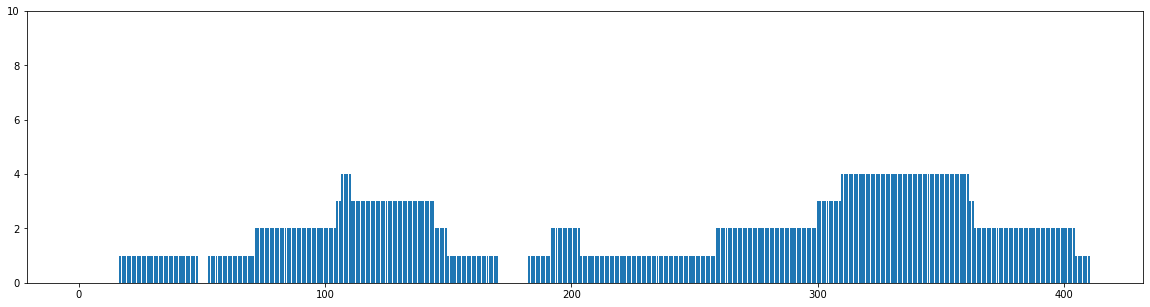

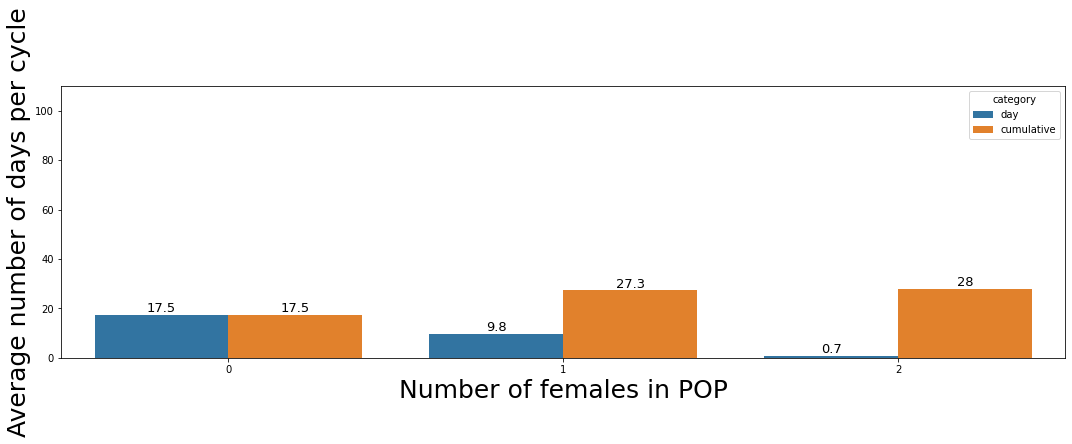

In [615]:
nMales = 10
nFemales = 10

seasonality = 1.0
sdDaysToConception = 50 * (1.0 - seasonality)
rangeOfNonCyclingDays = 365 - (365 * seasonality)

g = group(0)
g.go()

synchronyCharts(g)

print(g.modelDays)

nFemales = 10
nMales = 10

seasonality = 0.0
sdDaysToConception = 50 * (1.0 - seasonality)
rangeOfNonCyclingDays = 365 - (365 * seasonality)

g = group(0)
g.go()

synchronyCharts(g)

print(g.modelDays)

,# Males,# Females,Seasonality,Model Days
Model Data,10,10,0.0,412


,Rank,# of mates,RS,Cost,RS - Cost
Male 0,0,159,3.679295,0.786104,2.893191
Male 1,1,129,3.169871,0.874817,2.295054
Male 2,2,65,1.470626,0.496910,0.973715
Male 3,3,43,0.416878,0.640331,-0.223453
Male 4,4,0,0.000000,0.715439,-0.715439
Male 5,5,0,0.000000,0.688399,-0.688399
Male 6,6,0,0.000000,0.301675,-0.301675
Male 7,7,0,0.000000,0.393562,-0.393562
Male 8,8,0,0.000000,0.347596,-0.347596
Male 9,9,0,0.000000,0.253461,-0.253461


,RS,Days Before Cycling,Days Until Conception
Female 0,0.000000,105,6
Female 1,0.000000,17,32
Female 2,0.405201,53,92
Female 3,2.033918,192,172
Female 4,0.896085,72,78
Female 5,0.415659,183,21
Female 6,1.066173,259,103
Female 7,0.923844,107,64
Female 8,1.700485,310,95
Female 9,1.295304,300,111


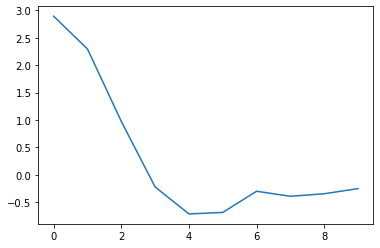

In [619]:
modelData = pd.DataFrame([[nMales, nFemales, seasonality, g.modelDays]],
                         columns=['# Males','# Females','Seasonality','Model Days'],
                         index=['Model Data'])

dataM =pd.DataFrame([[m.rank,m.matings,m.reproductiveSuccess,m.cost,m.reproductiveSuccess-m.cost] for m in g.males],
                         columns=['Rank','# of mates','RS', 'Cost', 'RS - Cost'],
                         index=["Male {}".format(i) for i in range(nMales)])

dataF =pd.DataFrame([[f.reproductiveSuccess, f.nonCyclingLength, f.cyclingLength] for f in g.females],
                         columns=['RS','Days Before Cycling','Days Until Conception'],
                         index=["Female {}".format(i) for i in range(nFemales)])
display(modelData)
display(dataM)
display(dataF)
plot([m.reproductiveSuccess-m.cost for m in g.males])

### donna
wild baby rescue hope 908-362-9453